In [1]:
# load a coffea file
from coffea.util import load
import os
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib
from hist import Hist

plt.style.use(hep.style.CMS)
from utils.plot.HEPPlotter import HEPPlotter

matplotlib.rcParams["figure.dpi"] = 300

In [2]:
# REGION='control_region'
# REGION='signal_region'
REGION='4b_region'
VARIATION='nominal'
NUM_EVENTS=-1
btag_wp_dict={
    # "L WP": [0.0499, "purple"],
    # "M WP": [0.2605, "magenta"],
    "T WP": [0.6915, "black"],
    "XT WP": [0.8033, "blue"],
    "XXT WP": [0.9664, "green"],
}

In [3]:

def get_cols_from_file(input, region=REGION):
    o = load(f"{input}")
    sample=list(o["columns"].keys())[0]
    dataset=list(o["columns"][sample].keys())[0]
    categories = list(o["columns"][sample][dataset].keys())
    print(f"sample: {sample}, dataset: {dataset} categories: {categories}")
    col=o["columns"][sample][dataset][region][VARIATION]

    for k in col.keys():
        # print(k)
        col[k]=col[k].value
        
    return col

In [4]:
input_file='/work/tharte/datasets/samples_no_model_input_for_spanet/loose_MC_postEE_pt_vary_btagWP/output_all.coffea'

cols = get_cols_from_file(input_file)

print(cols.keys())



sample: GluGlutoHHto4B_spanet_skimmed, dataset: GluGlutoHHto4B_spanet_kl-0p00_kt-0p00_c2-0p00_2022_postEE categories: ['4b_region']
dict_keys(['weight', 'weight_pileupUp', 'weight_pileupDown', 'JetGoodMatched_N', 'JetGoodMatched_provenance', 'JetGoodMatched_pt', 'JetGoodMatched_eta', 'JetGoodMatched_phi', 'JetGoodMatched_mass', 'JetGoodMatched_btagPNetB', 'JetGoodMatched_btagPNetB_wp', 'JetGoodHiggsMatched_N', 'JetGoodHiggsMatched_provenance', 'JetGoodHiggsMatched_pt', 'JetGoodHiggsMatched_eta', 'JetGoodHiggsMatched_phi', 'JetGoodHiggsMatched_mass', 'JetGoodHiggsMatched_btagPNetB', 'JetGoodHiggsMatched_btagPNetB_wp', 'JetGood_N', 'JetGood_provenance', 'JetGood_pt', 'JetGood_eta', 'JetGood_phi', 'JetGood_mass', 'JetGood_btagPNetB', 'JetGood_btagPNetB_wp', 'JetGoodHiggs_N', 'JetGoodHiggs_provenance', 'JetGoodHiggs_pt', 'JetGoodHiggs_eta', 'JetGoodHiggs_phi', 'JetGoodHiggs_mass', 'JetGoodHiggs_btagPNetB', 'JetGoodHiggs_btagPNetB_wp', 'events_random_pt_weights'])


In [5]:
NUMBER_OF_JETS=4
jet_type='JetGood'


jet_btag = ak.unflatten(cols[f'{jet_type}_btagPNetB'], cols[f'{jet_type}_N'])
# jet_btag_padded =ak.to_numpy(ak.pad_none(jet_btag, 5, clip=True), allow_missing=True)
jet_btag_padded=jet_btag

hist_dict = {}
eff_dict = dict(dict())
for name_wp in btag_wp_dict.keys():
    eff_dict[name_wp]=dict()
# plot histogram of btag scores separately for leading and subleading btag jets
for i in range(NUMBER_OF_JETS):
    var_name=f'Jet {i+1}'
    hist_w = Hist.new.Var(
                np.linspace(0.25, 1, 100),
                name=var_name,
                flow=False,
        ).Double()
    hist_w.fill(
        jet_btag_padded[:, i],
    )
    hist_dict[var_name] = {
        "data": hist_w,
    }
    
    #compute the efficiency for each working point for each jet
    for name_wp, (wp, color) in btag_wp_dict.items():
        eff = np.sum(jet_btag_padded[:, i] > wp) / np.sum(~np.isnan(jet_btag_padded[:, i]))
        print(f"Efficiency for {var_name} at {name_wp} ({wp}): {eff:.4f}")
        print(np.sum(jet_btag_padded[:, i] > wp))
        print(len(jet_btag_padded[:, i]))
        
        eff_dict[name_wp][var_name]=eff
    



Efficiency for Jet 1 at T WP (0.6915): 1.0000
132038
132038
Efficiency for Jet 1 at XT WP (0.8033): 0.9990
131910
132038
Efficiency for Jet 1 at XXT WP (0.9664): 0.9794
129312
132038
Efficiency for Jet 2 at T WP (0.6915): 0.9888
130564
132038
Efficiency for Jet 2 at XT WP (0.8033): 0.9713
128245
132038
Efficiency for Jet 2 at XXT WP (0.9664): 0.8373
110562
132038
Efficiency for Jet 3 at T WP (0.6915): 0.8898
117490
132038
Efficiency for Jet 3 at XT WP (0.8033): 0.8095
106884
132038
Efficiency for Jet 3 at XXT WP (0.9664): 0.5000
66025
132038
Efficiency for Jet 4 at T WP (0.6915): 0.5203
68705
132038
Efficiency for Jet 4 at XT WP (0.8033): 0.3982
52579
132038
Efficiency for Jet 4 at XXT WP (0.9664): 0.1438
18981
132038


T WP
Jet1: 100.0%
Jet2: 98.9%
Jet3: 89.0%
Jet4: 52.0%
XT WP
Jet1: 99.9%
Jet2: 97.1%
Jet3: 80.9%
Jet4: 39.8%
XXT WP
Jet1: 97.9%
Jet2: 83.7%
Jet3: 50.0%
Jet4: 14.4%


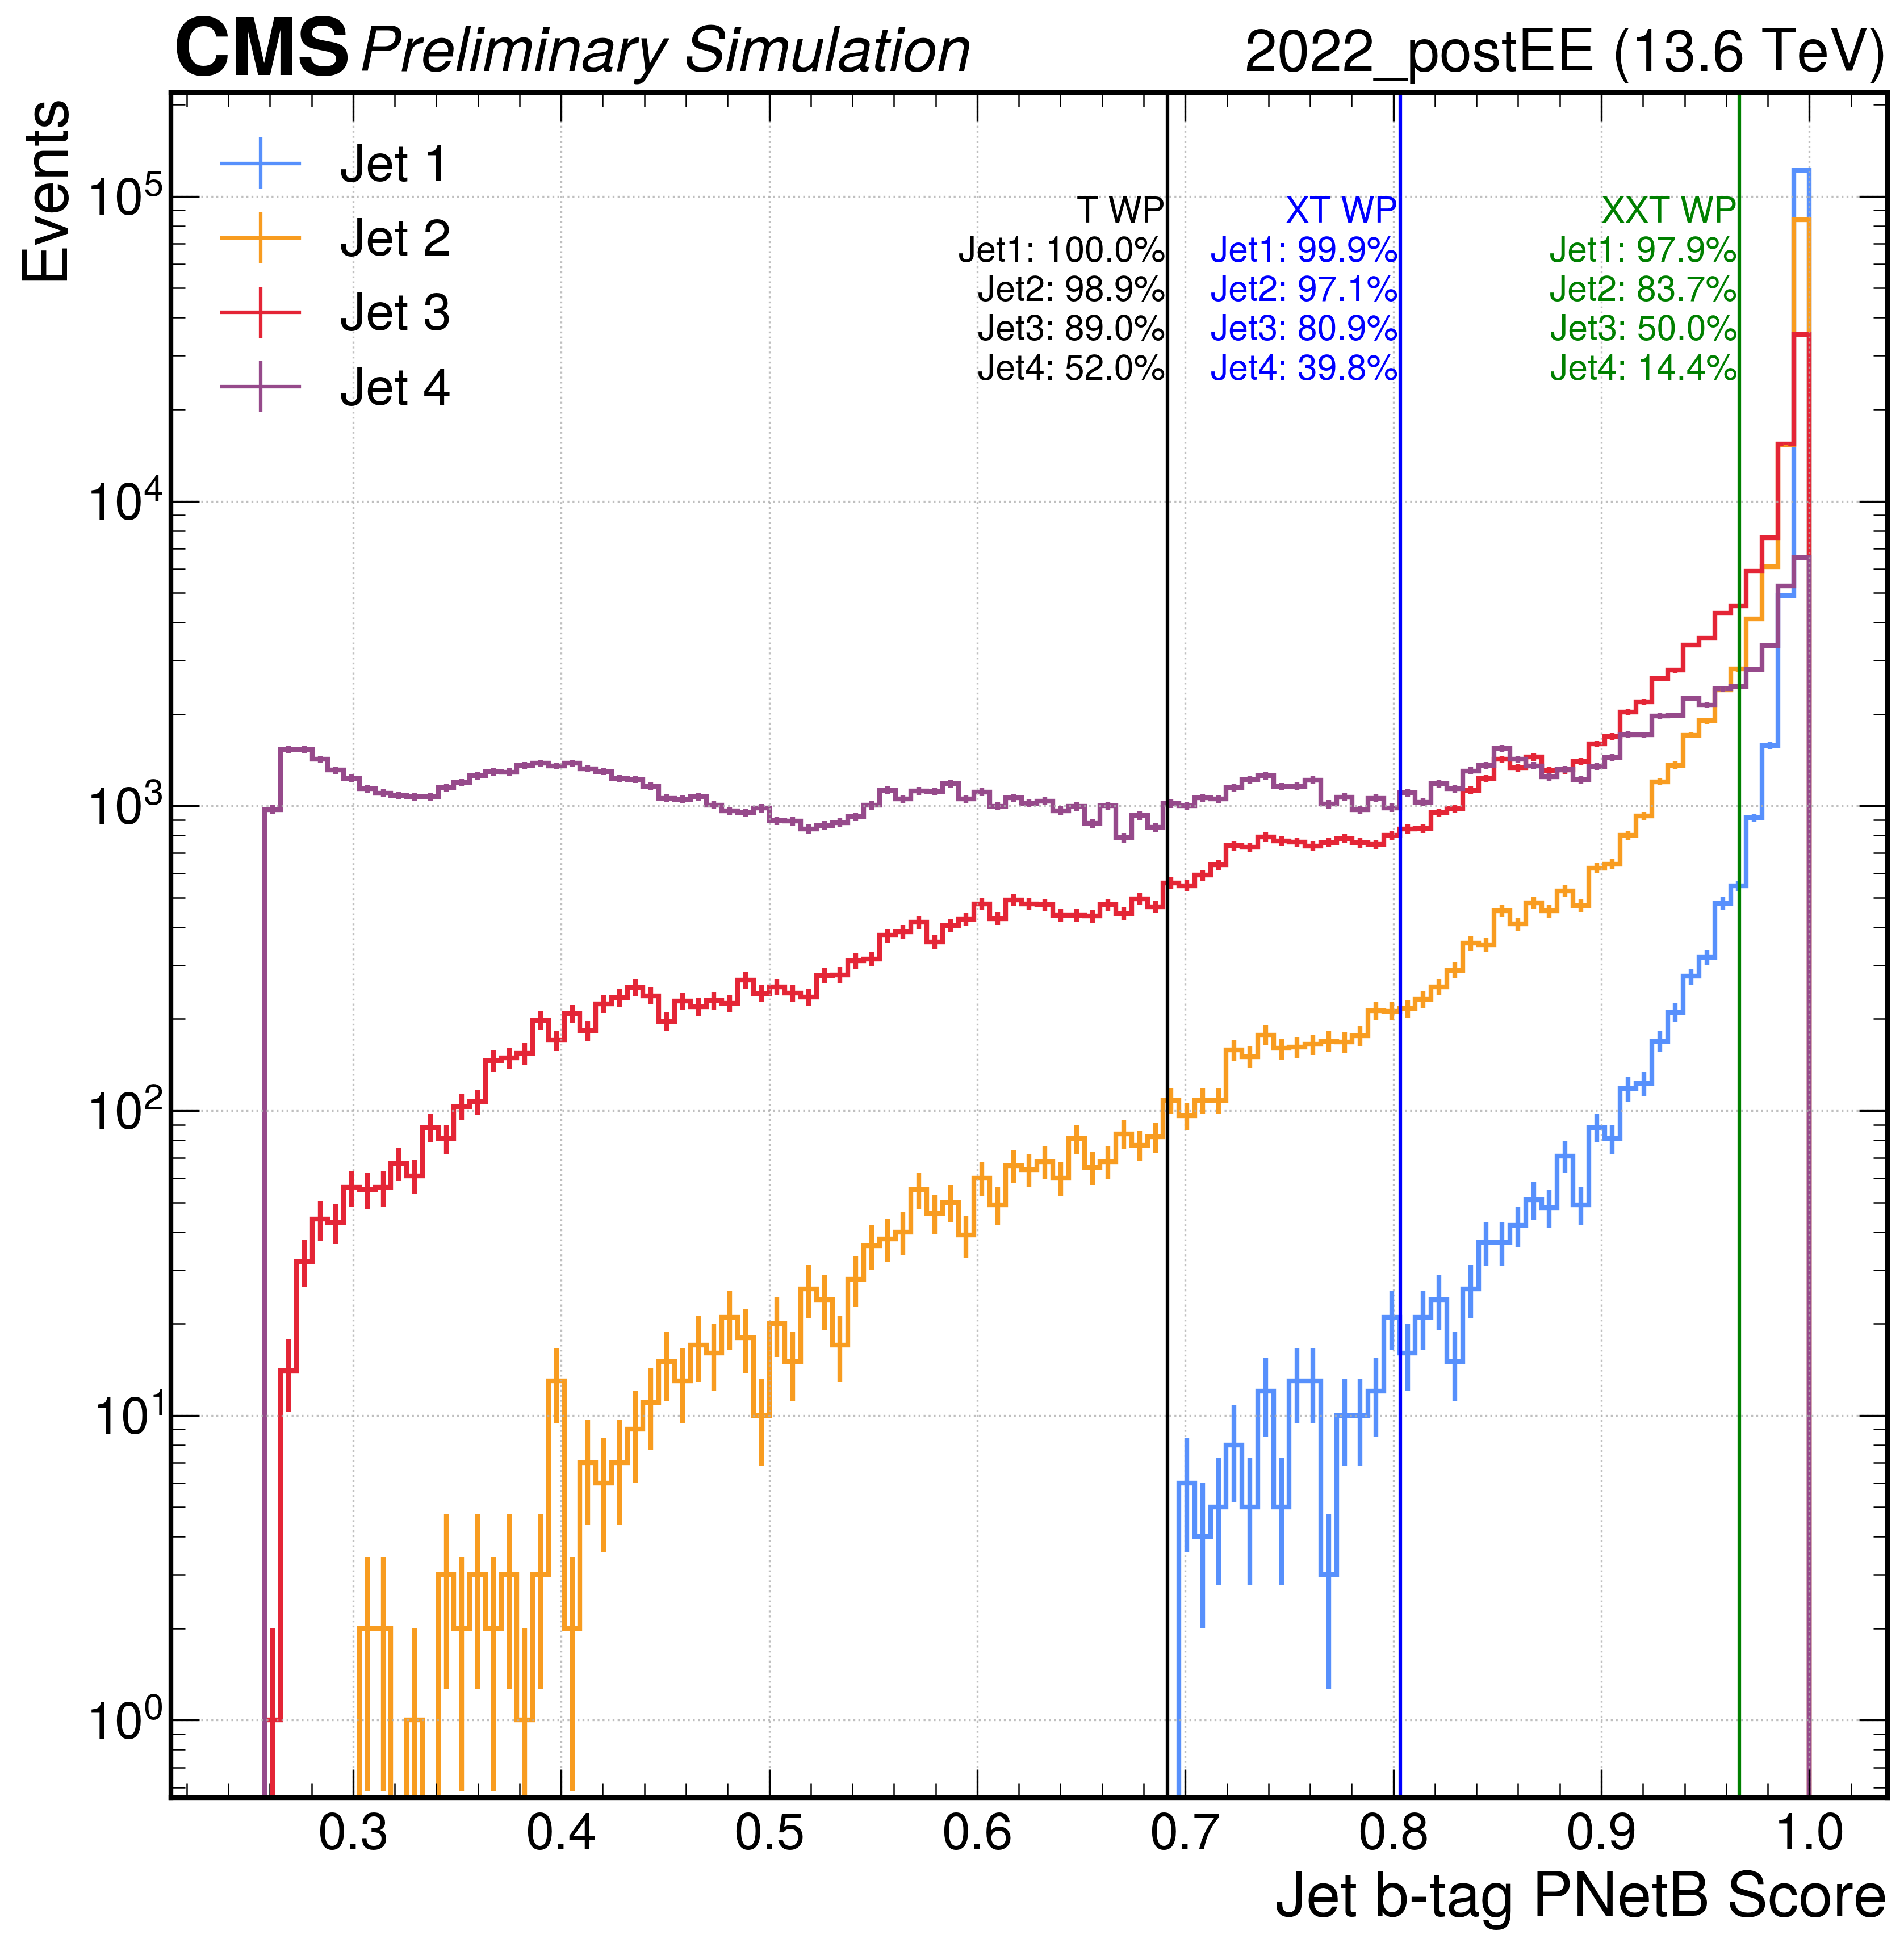

In [6]:
p = (
    HEPPlotter()
    .show()
    .set_plot_config(figsize=(13, 13), lumitext="2022_postEE (13.6 TeV)", cmstext="Preliminary Simulation")
    .set_labels(
        "Jet b-tag PNetB Score",
        "Events",
    )
    .set_options(y_log=True, x_log=False, set_ylim=False)
    .set_data(hist_dict, plot_type="1d")
)
for name_wp, (wp, color) in btag_wp_dict.items():
    string_efficiency = f"{name_wp}\n" +"\n".join([f"Jet{i+1}: {eff_dict[name_wp][f'Jet {i+1}']*100:.1f}%" for i in range(NUMBER_OF_JETS)])
    print(string_efficiency)
    
    p = p.add_line(orientation="v", x=wp, color=color).add_annotation(
        x=(wp - 0.001),
        y=1e5,
        s=string_efficiency,
        color=color,
        fontsize=15,
        ha="right",
        va="top",
        coord_type="data"
    )

p.run()